## **La Arquitectura de ResNet-34**

La arquitectura sigue una estructura muy clara:

- Capa inicial: Una convolución grande para capturar características generales.

- Cuatro Etapas: Cada etapa está compuesta por una pila de bloques residuales básicos.

- Etapa 1 (conv2_x): 3 bloques residuales con 64 filtros.

- Etapa 2 (conv3_x): 4 bloques residuales con 128 filtros (aquí se reduce el tamaño espacial).

- Etapa 3 (conv4_x): 6 bloques residuales con 256 filtros (se vuelve a reducir el tamaño).

- Etapa 4 (conv5_x): 3 bloques residuales con 512 filtros (última reducción de tamaño).

- Capa final: Un pooling y una capa densa para la clasificación.

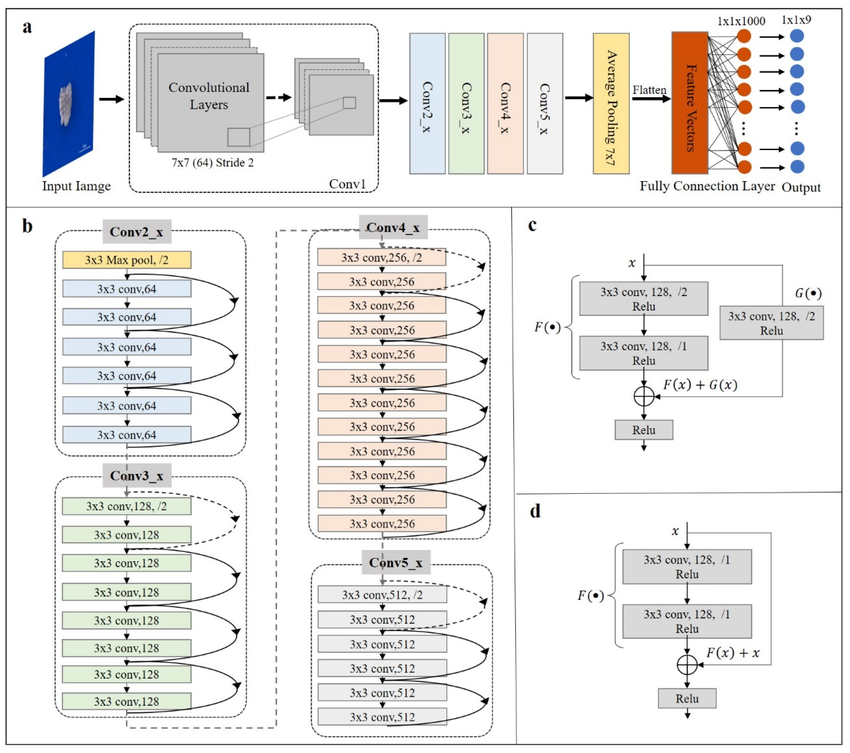

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
def bloque_residual(x, filtros, stride=1, es_atajo_convolucional=False):
    """
    Un bloque residual básico con dos capas convolucionales de 3x3.
    """
    # Skip Connection
    x_atajo = x

    # Primer camino convolucional
    x = Conv2D(filtros, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Segundo camino convolucional
    x = Conv2D(filtros, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    # --- El Atajo ---
    # Si necesitamos ajustar las dimensiones del atajo (ya sea por stride > 1 o cambio en filtros).
    if es_atajo_convolucional:
        x_atajo = Conv2D(filtros, kernel_size=1, strides=stride, padding='same')(x_atajo)
        x_atajo = BatchNormalization()(x_atajo)

    # Sumamos la salida del camino principal con la del atajo
    x = Add()([x, x_atajo])
    x = Activation('relu')(x)

    return x

In [ ]:
def crear_resnet34(input_shape=(224, 224, 3), num_clases=1000):
    """
    Construye el modelo ResNet-34 completo.
    """
    inputs = Input(shape=input_shape)

    # Etapa inicial (conv1)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Etapa 2 (conv2_x) - 3 bloques residuales
    x = bloque_residual(x, filtros=64)
    x = bloque_residual(x, filtros=64)
    x = bloque_residual(x, filtros=64)

    # Etapa 3 (conv3_x) - 4 bloques
    x = bloque_residual(x, filtros=128, stride=2, es_atajo_convolucional=True) # Primer bloque reduce tamaño
    x = bloque_residual(x, filtros=128)
    x = bloque_residual(x, filtros=128)
    x = bloque_residual(x, filtros=128)

    # Etapa 4 (conv4_x) - 6 bloques
    x = bloque_residual(x, filtros=256, stride=2, es_atajo_convolucional=True) # Primer bloque reduce tamaño
    x = bloque_residual(x, filtros=256)
    x = bloque_residual(x, filtros=256)
    x = bloque_residual(x, filtros=256)
    x = bloque_residual(x, filtros=256)
    x = bloque_residual(x, filtros=256)

    # Etapa 5 (conv5_x) - 3 bloques
    x = bloque_residual(x, filtros=512, stride=2, es_atajo_convolucional=True) # Primer bloque reduce tamaño
    x = bloque_residual(x, filtros=512)
    x = bloque_residual(x, filtros=512)

    # Capas finales
    x = AveragePooling2D(pool_size=7, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_clases, activation='softmax')(x)

    # Creamos el modelo final
    model = Model(inputs=inputs, outputs=outputs, name="ResNet34")
    return model

In [ ]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASES = 1000

modelo_resnet34 = crear_resnet34(input_shape=INPUT_SHAPE, num_clases=NUM_CLASES)

modelo_resnet34.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

modelo_resnet34.summary()

Model: "ResNet34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 21,823,208 (83.25 MB)

 Trainable params: 21,806,184 (83.18 MB)

 Non-trainable params: 17,024 (66.50 KB)